# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [324]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import networkx as nx

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from transducive_learning_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load processed data

In [132]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print("\n\n\nThe vote dataframe is a " + str(votes.shape) + " table with senators as rows and vote positions as columns.")
display(votes.head(3))

# Separate votes into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.80, votes)

senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The vote dataframe is a (105, 104) table with senators as rows and vote positions as columns.


id         hconres71-115-224  hconres71-115-227  hconres71-115-231  \
member_id                                                            
A000360                 -1.0               -1.0               -1.0   
B000575                  0.0               -1.0               -1.0   
B000944                  1.0                1.0                1.0   

id         hconres71-115-234  hjres38-115-43  hr1-115-285  hr1-115-286  \
member_id                                                                
A000360                 -1.0             1.0         -1.0         -1.0   
B000575                 -1.0             1.0         -1.0         -1.0   
B000944                  1.0            -1.0          1.0          1.0   

id         hr1-115-287  hr1-115-288  hr1-115-289       ...        \
member_id                                              ...         
A000360           -1.0         -1.0         -1.0       ...         
B000575           -1.0         -1.0         -1.0       ...         
B000944            1.0          1.0          1.0       ...         

id         sconres3-115-22  sconres3-115-23  sconres3-115-24  sconres3-115-25  \
member_id                                                                       
A000360                1.0             -1.0              1.0             -1.0   
B000575                1.0             -1.0              1.0             -1.0   
B000944               -1.0              1.0             -1.0              1.0   

id         sconres3-115-4  sconres3-115-5  sconres3-115-6  sconres3-115-7  \
member_id                                                                   
A000360              -1.0            -1.0            -1.0            -1.0   
B000575               0.0            -1.0            -1.0            -1.0   
B000944               1.0            -1.0             1.0             1.0   

id         sconres3-115-8  sconres3-115-9  
member_id                                  
A000360              -1.0             1.0  
B000575              -1.0             1.0  
B000944               1.0            -1.0  

[3 rows x 104 columns]




The senators dataframe is a (105, 4) table with senators as rows and ID, party and names as columns.


party first_name  last_name             name
member_id                                             
A000360       R      Lamar  Alexander  Lamar Alexander
B000575       R        Roy      Blunt        Roy Blunt
B000944       D    Sherrod      Brown    Sherrod Brown

## Load labels

## Building the similarity graph

In [493]:
features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg, 15),0.5)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)

G = graphs.Graph(adjacency)
G = reduction.graph_sparsify(G, 0.25)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

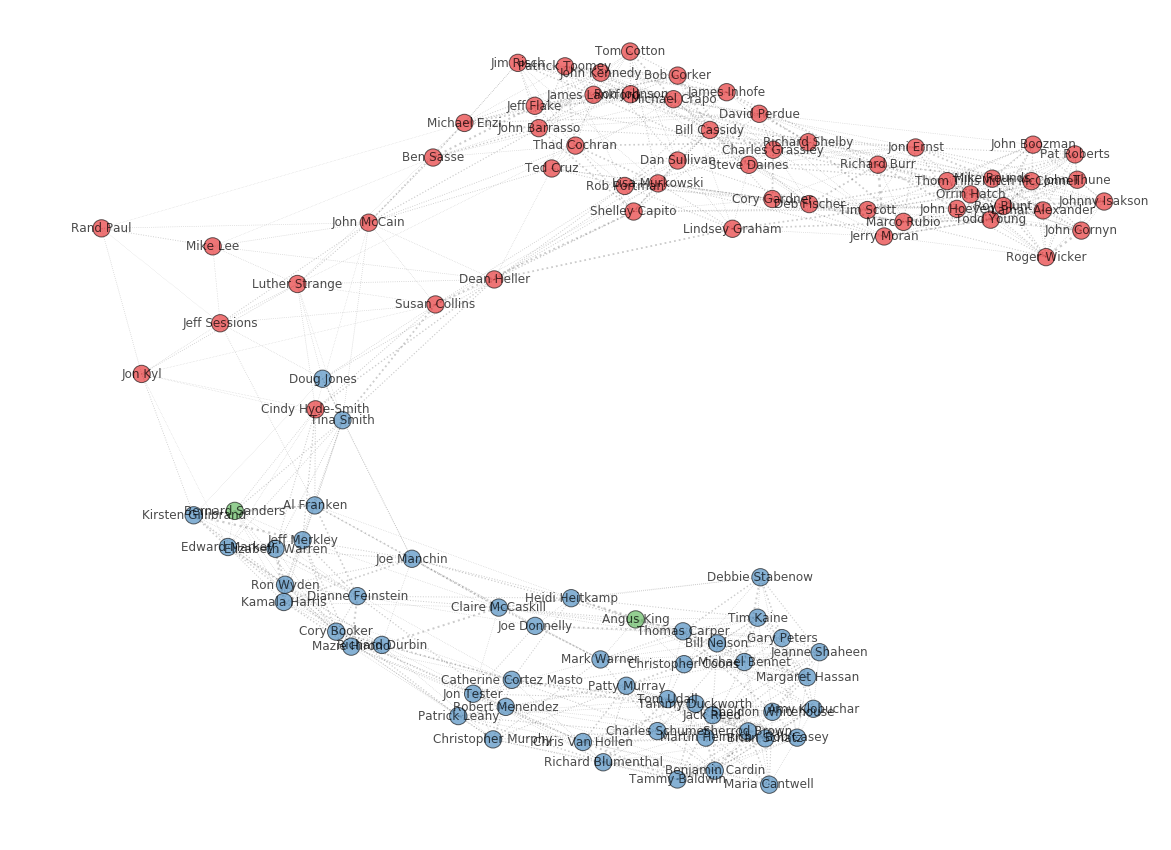

In [494]:
plot_signal(G.W.todense(), numerical_labels, labels=senators['name'], scale=[0,1])

## Clustering the bills

Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

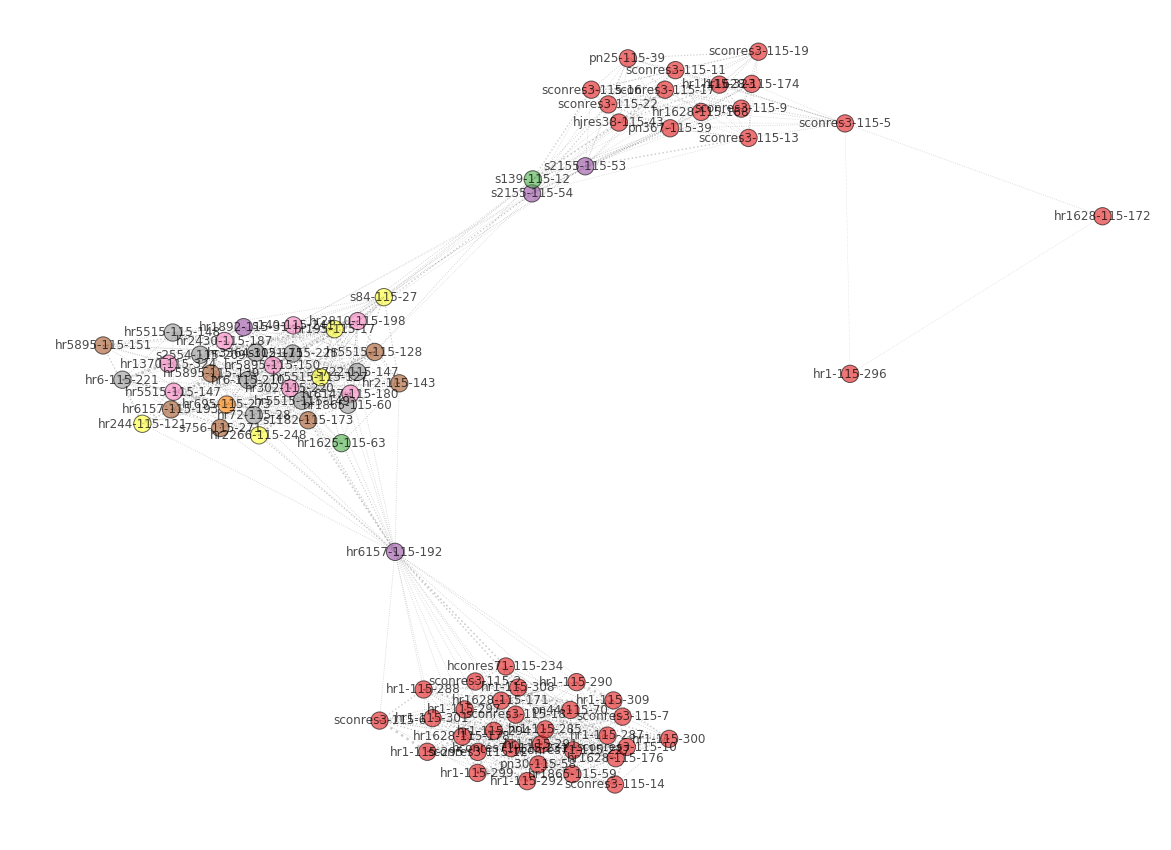

In [203]:
bill_cluster_count = 3

features_bills = [votes_train.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(arg,0.7)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

G_bills = graphs.Graph(adjacency_bills)
G_bills = reduction.graph_sparsify(G_bills,0.25)

plot_signal(G_bills.W.todense(), votes_train.sum(0) / votes_train.shape[0], labels=votes_train.T.index, scale=[0,1])

### Method 1: Get biggest Variance

In [176]:
var = np.zeros(votes_train.shape[1])

for i in range(votes_train.shape[1]):
    a = votes_train.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([59, 20, 61], dtype=int64)

### Method 2: Get smallest number of neighbors

In [205]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([ 1, 40, 23], dtype=int64)

### Method 3: Get closest points of the centers of the cluster of the Bills

In [261]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()

embedding = G_bills.U[:,1:1+bill_cluster_count]
clusters, centers = gen_kmeans(embedding,bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    min_ = 1000;
    for i in range(embedding.shape[0]):
        dist = np.linalg.norm(embedding[i] - centers[j])
        if dist < min_:
            min_ = dist
            vote_repr[j] = i
            
vote_repr

array([44., 67., 11.])

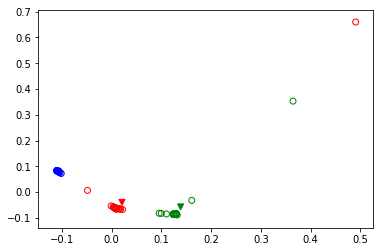

In [262]:
n = len(embedding)
colors = {0:'red',1:'blue',2:'green'}

for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[clusters[i]])
    
plt.scatter(centers[:,0], centers[:,1], marker='v', color=list(colors.values()))

### Method 4: Get the bills with biggest intracluster std

In [266]:
var = np.zeros(votes_train.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes.iloc[rep_indexes]
dem_data = votes.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([15, 29, 39], dtype=int64)

In [267]:
stds

array([0.14740555, 0.        , 0.        , 0.        , 0.42041972,
       0.        , 0.        , 0.        , 0.        , 0.24690906,
       0.        , 0.        , 0.28177133, 0.38424422, 0.        ,
       0.86553895, 0.        , 0.44221664, 0.38232557, 0.28316568,
       0.13733516, 0.        , 0.13864839, 0.24944383, 0.        ,
       0.        , 0.        , 0.36367131, 0.67864621, 0.8753854 ,
       0.37831376, 0.        , 0.        , 0.39411349, 0.19230769,
       0.31125698, 0.        , 0.49442341, 0.28430489, 0.88987506,
       0.66210604, 0.41724588, 0.48153785, 0.46908888, 0.        ,
       0.48      , 0.48054248, 0.52207014, 0.48193632, 0.13733516,
       0.69287368, 0.56225979, 0.47371036, 0.19595918, 0.19595918,
       0.4586858 , 0.2712932 , 0.4142463 , 0.13864839, 0.14      ,
       0.47370877, 0.32780364, 0.49952719, 0.33678116, 0.73382463,
       0.        , 0.20608041, 0.        , 0.        , 0.        ,
       0.43002668, 0.84414965, 0.30832716, 0.47628048, 0.47628

## Vote selection

['hr1-115-294' 'hr5515-115-149' 'pn367-115-39']


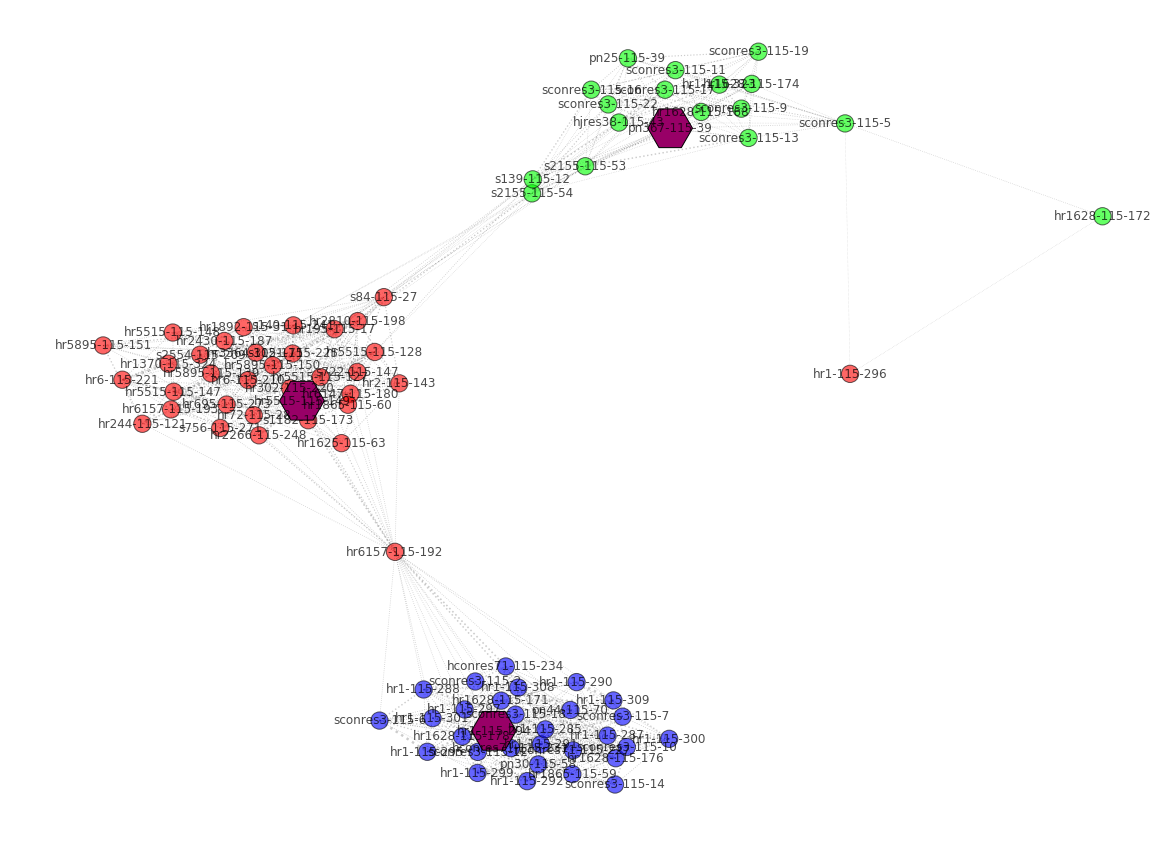

In [260]:
vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,2], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('brg'))

## Embedding you in the graph

In [302]:
your_votes = [1,1,-1]
other_senators_vote = votes_train.values[:,vote_selection]

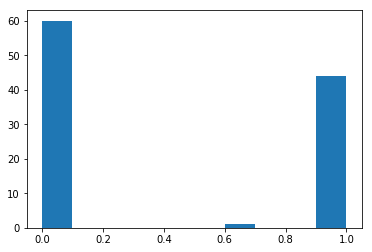

In [341]:
def compute_similarity(senator_votes):
    return euclidean_distance(senator_votes, your_votes)

similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote)
similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)
plt.hist(similarity_vector)
plt.show()

In [421]:
new_columns = np.append(similarity_vector, 0)

n = len(adjacency)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns

G_new = graphs.Graph(new_adjacency)
G_new.set_coordinates('spring', seed=2018)
G_new.compute_fourier_basis()
G_new.compute_laplacian()
G_new.compute_differential_operator()

new_labels = np.append(senators['name'].values, ['you'])

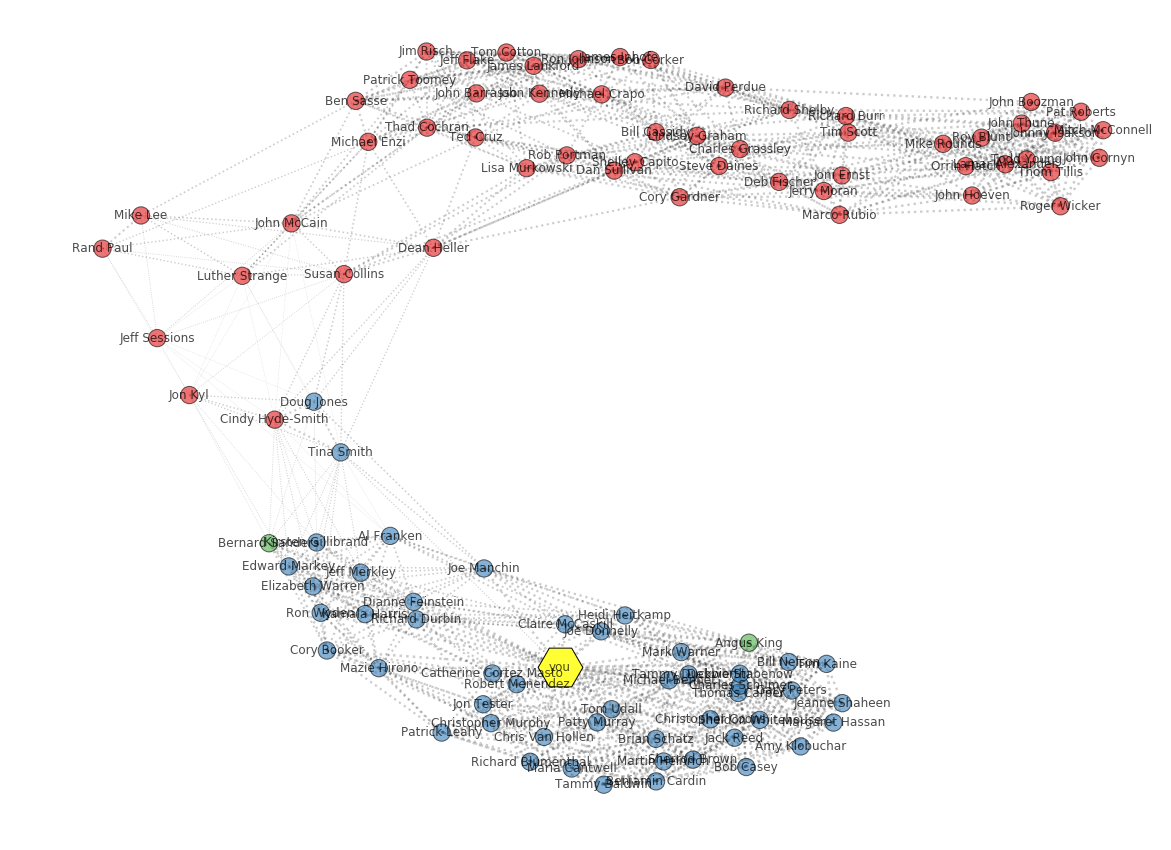

In [305]:
plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])

## Spectral analysis of the new adjacency matrix

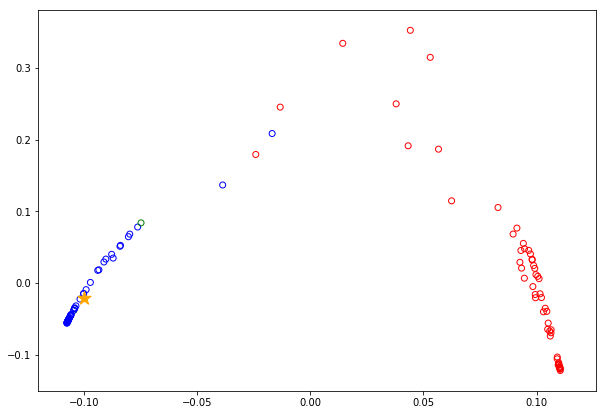

In [346]:
embedding = G_new.U[:,1:3]

colors = {'R':'red','D':'blue','I':'green'}

plt.figure(figsize=(10,7))

n = len(embedding)
for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[senators_party[i]])
    
plt.scatter(embedding[n-1,0], embedding[n-1,1], color='orange', s=200, marker='*')
plt.show()

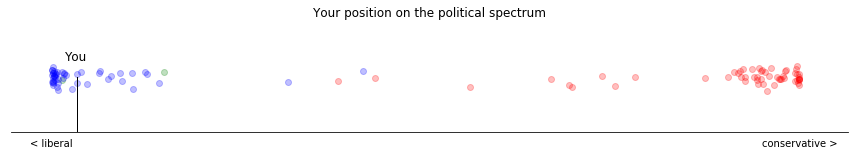

In [332]:
show_political_spectrum(embedding, n, colors, senators_party)

# Predicting votes based on votes from similar senators

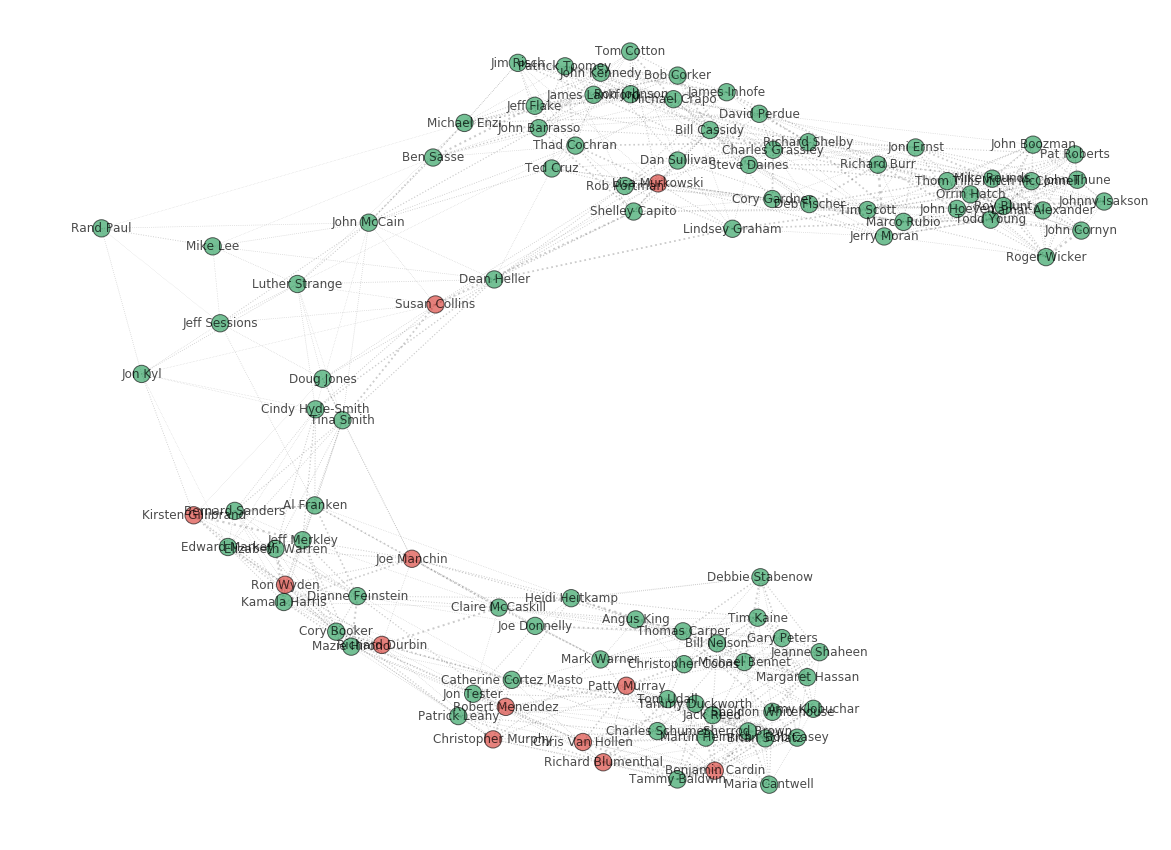

In [525]:
# Binarize labels
labels_bin = get_labels(votes_test.values[:,1], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

In [603]:
a = np.array([1,2,3])
b = np.array([2,3,4])

c = [a,b]

print(np.median(c, axis=0))

[1.5 2.5 3.5]


In [617]:
def get_signal_predicted(G, mask, labels_bin, threshold = 0, number_of_trials=100, verbose = 'NONE'):

    sols = []
    
    for _ in range(number_of_trials):
        sols.append(graph_pnorm_interpolation(
            G.D,
            P_wrapper(mask, labels_bin),
            np.random.normal(loc=0, scale=1,size=n), 
            2,
            verbosity=verbose
        ))
        
    return get_thresholded_values(np.median(sols,axis=0), threshold)


Error: 0.4364357804719848
Accuracy: 0.9523809523809523


<Figure size 1440x1296 with 0 Axes>

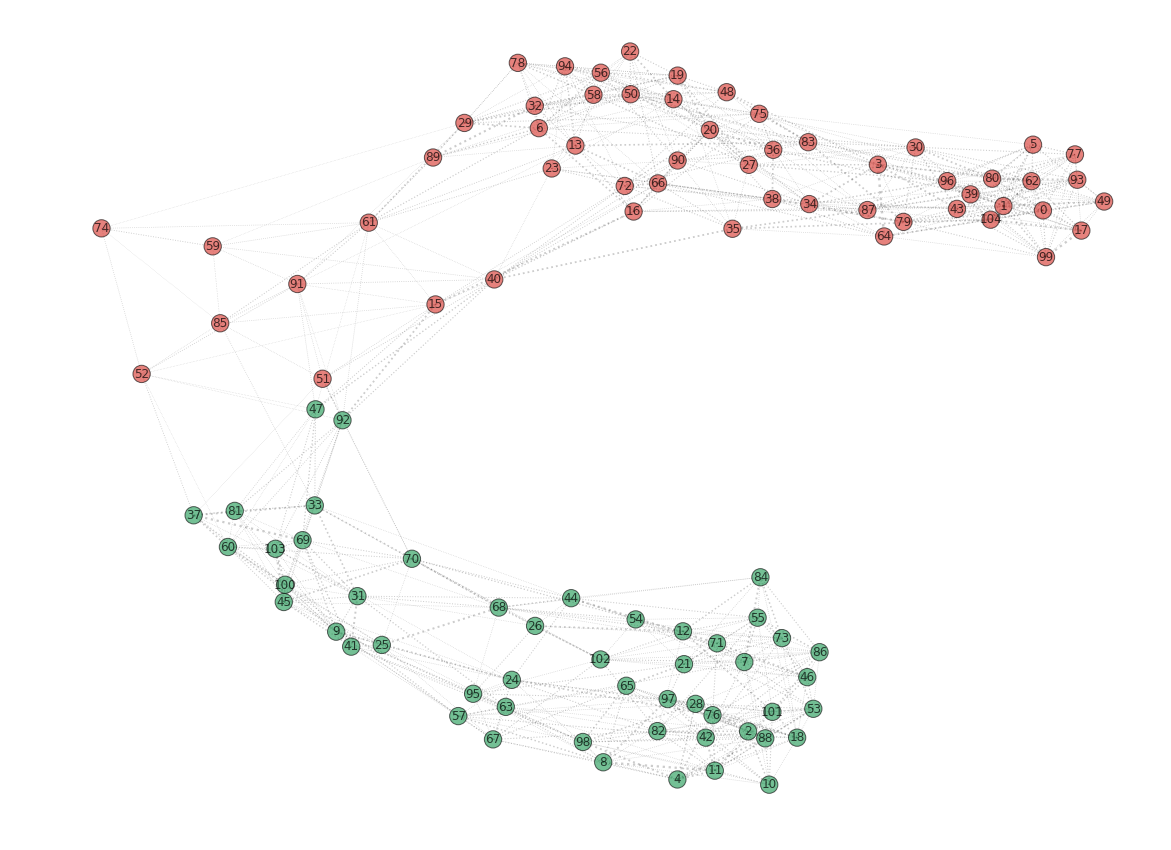

In [619]:
sol_2norm_bin =  get_signal_predicted(G,w,labels_bin)

plt.figure(figsize=(20,18))
print("Error: " + str(error(labels_bin, sol_2norm_bin)))
print("Accuracy: " + str(accuracy(labels_bin, sol_2norm_bin)))
plot_signal(G.W.todense(), sol_2norm_bin, scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))
plt.show()

# What about you ?


In [431]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    idx = np.argwhere(bill_votes!=0)
    w = np.append(np.ones(votes_test.shape[0]), [0])    
    
    sol_norm_min = np.zeros(n+1)
    
    for i in range(number_of_trials):
        sol_norm_min += graph_pnorm_interpolation(
            G.D,
            P_wrapper(w, bill_votes),
            np.random.randn(n+1),
            p,
            verbosity='NONE'
        ) / number_of_trials
        
    print(sol_norm_min[-1])
    
    return get_thresholded_values(sol_norm_min,0)

to_predict = 44
#hr1-115-294 hr5515-115-149' 'pn367-115-39 
sol_norm_min = predict_your_votes(G_new, votes['sconres3-115-19'])
print("On vote x you would have voted " + str(sol_norm_min[-1]))

-0.8030825503866509
On vote x you would have voted -1.0


In [24]:
def get_closest_senators_id(adjacency,number_of_senators):
        close_senators = adjacency[-1,:].copy()
        close_senators = close_senators[close_senators > 0]
        num = min(number_of_senators,close_senators.shape[0])
        return np.argsort(adjacency[-1,:])[-num:]

get_closest_senators_id(new_adjacency,3)

array([ 85, 100,  37], dtype=int64)

# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters

In [661]:
def compare_outcome(pred, labels):
    true_results = dict(zip(*np.unique(labels.astype(int), return_counts=True)))
    true_outcome = true_results.get(1,0) > true_results.get(-1,0)
    
    pred_results = dict(zip(*np.unique(pred.astype(int), return_counts=True)))
    pred_outcome = pred_results.get(1,0) > pred_results.get(-1,0)
    
    #print("True: "+str(true_results) + " Pred: " + str(pred_results))
    
    return pred_outcome == true_outcome

In [662]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

print(senators['name'].iloc[swing_senators])
                            
individual_accuracies = []
outcome_comparison = []

for i in range(votes_test.shape[1]):
    labels_bin = get_labels(votes_test.values[:,i], 0.0)
    mask = np.zeros(len(senators_party))
    mask[swing_senators] = 1
    pred = get_signal_predicted(G, mask, labels_bin, number_of_trials=100)
    accuracies.append(accuracy(pred,labels_bin))
    outcome_comparison.append(compare_outcome(pred, labels_bin))
    
print("Outcome accuracy: " + str(np.mean(outcome_comparison)))

member_id
C001035       Susan Collins
F000457          Al Franken
H001041         Dean Heller
H001079    Cindy Hyde-Smith
J000300          Doug Jones
K000352             Jon Kyl
S001141       Jeff Sessions
S001202      Luther Strange
S001203          Tina Smith
Name: name, dtype: object
Outcome accuracy: 0.8095238095238095
